# P5 - Segmentez des clients d'un site e-commerce


Nous allons entamer la segmentation de la clientèle.

Nous prodcederons par une segmentation RFM qui permet un classement
des clients en fonction de leurs habitudes d'achat défini par leur :

- Récence d'achat
- Fréquence d'achat
- Montant d'achat.


Pour ce faire, différentes techniques de segmentation sont utilisés:
- segmentation standard par l'établissement d'un score 
- segmentation K-Means, DBScan ou encore Agglomerative Clustering

Rappelons que l'objectif sera d'obtenir des segmentations qui soient à la fois cohérentes et exploitables.
Cette évaluation se fera en analysant : Nombre de Clusters / Nombre de Clients par Cluster et interprétation de chaque type de cluster

Ce processus sera répété au fur et à mesur que nous  ajoutanerons des features aux RFM existantes, une à une.

## 1- RFM Segmentation_Score

Rappel : La segmentation RFM repose sur ces 3 critères :
Récence : date du dernier achat ou dernier contact client,
Fréquence : fréquence des achats sur une période de référence donnée,
Montant : somme (ou moyenne) des achats cumulés sur cette période
Nous avons déja constitué ces variables dans le notebook P05_01_notebookanalyse
Dans le but d’établir un score basé sur la méthode RFM, les critères spécifiques Récence-Fréquence-Montant seront découpés en catégories. Mais avant regardons ce que donne le découpage des données en quantiles 

In [200]:
# chargement librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Clustering
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import decomposition,manifold
from sklearn import preprocessing
from sklearn import cluster, metrics
from scipy.spatial.distance import cdist

In [201]:
# chargement dataset rfm
rfm=pd.read_csv('rfm.csv')

In [202]:
#dimensions
rfm.shape

(91212, 4)

In [203]:
# premieres lignes
rfm.head(3)

,customer_unique_id,recence,freq,montant_sum
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
2,0000f46a3911fa3c0805444483337064,536,1,86.22


In [204]:
# description
rfm.describe()

,recence,freq,montant_sum
count,91212.000000,91212.000000,91212.000000
mean,236.109415,1.237666,212.352124
std,152.573347,0.844734,631.928631
min,0.000000,1.000000,9.590000
25%,113.000000,1.000000,63.830000
50%,217.000000,1.000000,112.880000
75%,344.000000,1.000000,202.760000
max,694.000000,75.000000,109312.640000


In [205]:
#découpage en quantiles
quantiles = rfm.quantile(q=[0.20, 0.4, 0.6,0.8])    
print(quantiles)

     recence  freq  montant_sum
0.2     90.0   1.0       56.010
0.4    175.0   1.0       89.744
0.6    267.0   1.0      139.966
0.8    380.0   1.0      238.396


In [206]:
# transformer le découpage en dictionnaire pour pouvoir attribuer les notes
quantiles=quantiles.to_dict()
quantiles

{'recence': {0.2: 90.0, 0.4: 175.0, 0.6: 267.0, 0.8: 380.0},
 'freq': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'montant_sum': {0.2: 56.01,
  0.4: 89.74400000000001,
  0.6: 139.96599999999998,
  0.8: 238.39600000000007}}

In [207]:
# attribution des scores
def R_score(x,q,v):
    """return recence score"""
    if x<=v[q][0.2]:
        return 5
    elif x<=v[q][0.4]:
        return 4
    elif x<=v[q][0.6]:
        return 3
    elif x<=v[q][0.8]:
        return 2
    else:
        return 1

def FM_score(x,q,v):
    """return frequency and montant score"""
    if x<=v[q][0.2]:
        return 1
    elif x<=v[q][0.4]:
        return 2
    elif x<=v[q][0.6]:
        return 3
    elif x<=v[q][0.8]:
        return 4
    else:
        return 5
    

### precisions
### Meilleur score de récence : 5 : le dernier achat est le plus récent.
### Meilleur score de fréquence : 5 : les achats sont les plus fréquents.
### Meilleur score de montant : 5 : le montant le plus élevé.
### --> 5-5-5 donc un score =15 : clients VIP
### --> 1-1-1 donc un score =3 : clients les moins intéressants 

In [208]:
# tableau avec les scores
rfm['r_quantile']=rfm['recence'].apply(R_score,args=('recence',quantiles))
rfm['f_quantile']=rfm['freq'].apply(FM_score,args=('freq',quantiles))
rfm['m_quantile']=rfm['montant_sum'].apply(FM_score,args=('montant_sum',quantiles))


In [209]:
rfm.head()

,customer_unique_id,recence,freq,montant_sum,r_quantile,f_quantile,m_quantile
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,4,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4,1,1
2,0000f46a3911fa3c0805444483337064,536,1,86.22,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,2,1,4


In [210]:
# calcul score
rfm['RFM_score'] = rfm[['r_quantile', 'f_quantile', 'm_quantile']].sum(axis=1)
rfm.head()

,customer_unique_id,recence,freq,montant_sum,r_quantile,f_quantile,m_quantile,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,4,1,4,9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4,1,1,6
2,0000f46a3911fa3c0805444483337064,536,1,86.22,1,1,2,4
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,2,1,1,4
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,2,1,4,7


In [211]:
# ajouter le segment
rfm['RFM_segment'] = rfm.apply(lambda x: str(x['r_quantile']) +
                                               str(x['f_quantile']) + str(x['m_quantile']),
                                               axis=1)

In [212]:
rfm.head()

,customer_unique_id,recence,freq,montant_sum,r_quantile,f_quantile,m_quantile,RFM_score,RFM_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,4,1,4,9,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4,1,1,6,411
2,0000f46a3911fa3c0805444483337064,536,1,86.22,1,1,2,4,112
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,2,1,1,4,211
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,2,1,4,7,214


In [212]:
rfm.head()

,customer_unique_id,recence,freq,montant_sum,r_quantile,f_quantile,m_quantile,RFM_score,RFM_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,4,1,4,9,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4,1,1,6,411
2,0000f46a3911fa3c0805444483337064,536,1,86.22,1,1,2,4,112
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,2,1,1,4,211
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,2,1,4,7,214


In [213]:
# modalités de scores
rfm.RFM_score.unique()

array([ 9,  6,  4,  7, 13,  8,  3,  5, 10, 12, 15, 14, 11], dtype=int64)

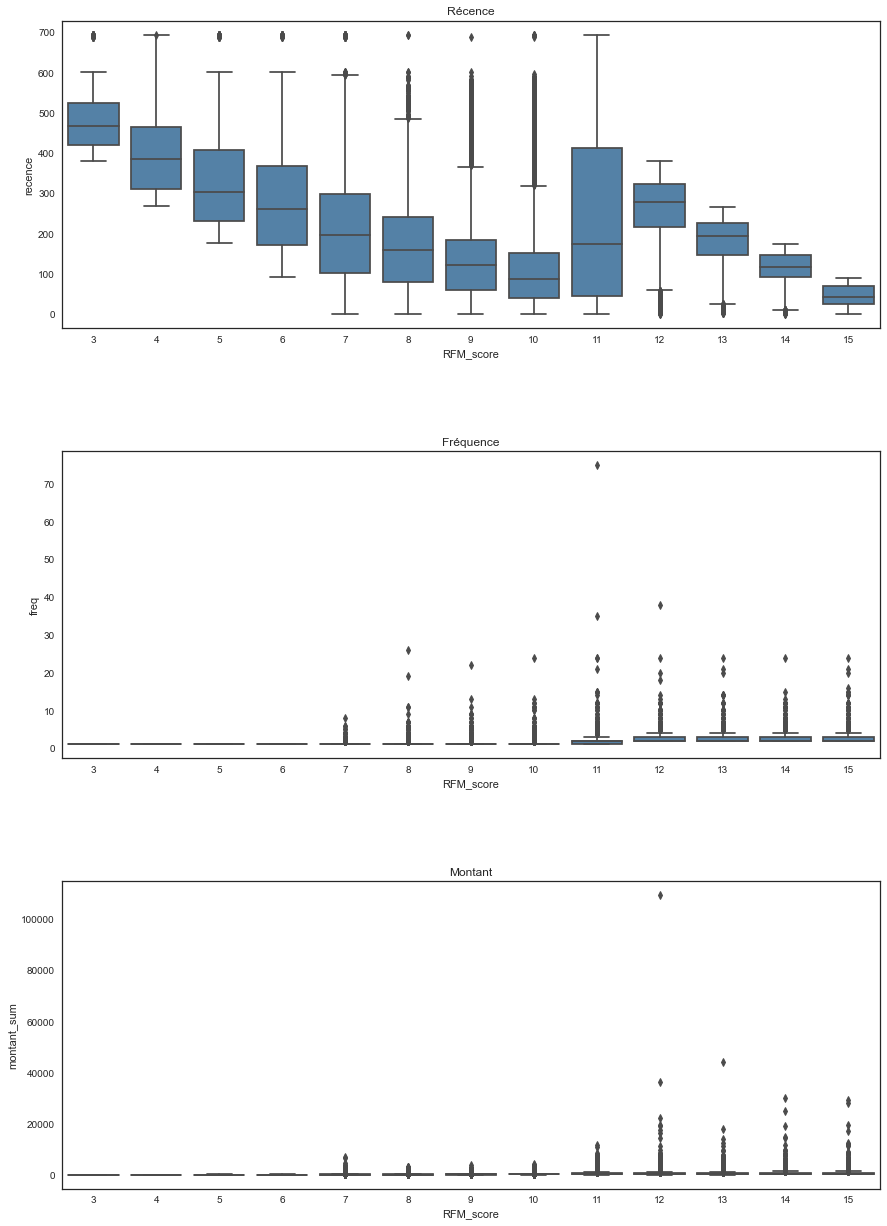

In [214]:
# regardons le score en fonction du RFM
fig, axs = plt.subplots(3, 1)
fig.subplots_adjust(left=0.08, right=1.5, bottom=0.05,
                    top=3, hspace=0.4, wspace=0.3)

# Boxplot Récence
sns.boxplot(x='RFM_score', y='recence', data= rfm,
            color='SteelBlue', ax=axs[0])
axs[0].set_title('Récence')

# Boxplot Fréquence
sns.boxplot(x='RFM_score', y='freq', data=rfm,
            color='SteelBlue', ax=axs[1])
axs[1].set_title('Fréquence')

# Boxplot Montant
sns.boxplot(x='RFM_score', y='montant_sum', data=rfm,
            color='SteelBlue', ax=axs[2])
axs[2].set_title('Montant')

plt.show()

In [215]:
# calcul des moyennes pour chaque variable pour chaque score
moy_var = rfm.groupby("RFM_score")[['recence', 'freq', 'montant_sum']].agg([np.mean, np.var])
moy_var["%_clients"] = rfm.groupby('RFM_score')[['recence']].agg([np.size])/91231*100
moy_var

recence                    freq           montant_sum  \
                 mean           var      mean       var        mean   
RFM_score                                                             
3          474.164519   3890.033815  1.000000  0.000000   39.847159   
4          394.474037   8703.909756  1.000000  0.000000   56.841349   
5          328.249836  12290.665028  1.000000  0.000000   73.079503   
6          278.052147  16506.907878  1.000000  0.000000   98.358778   
7          215.064761  21083.389920  1.012861  0.024520  151.600902   
8          167.019609  11417.819389  1.040515  0.166592  181.412054   
9          134.550915  10039.131890  1.091637  0.239574  208.510518   
10         127.999846  16361.165948  1.226930  0.506122  280.545491   
11         229.122418  37983.914006  1.887692  3.175118  511.125437   
12         262.075521   7176.622877  2.598958  2.312496  653.792009   
13         180.458824   3952.805223  2.531846  1.827009  580.353124   
14         110.674304   2012.720391  2.636119  1.974497  712.728872   
15          46.255597    638.737990  2.813433  3.024287  848.571797   

                         %_clients  
                    var             
RFM_score                           
3          9.177267e+01   3.997545  
4          3.476605e+02   7.514989  
5          1.006144e+03  11.692298  
6          2.940044e+03  14.419441  
7          5.030811e+04  16.874747  
8          4.282642e+04  13.527200  
9          3.946485e+04   9.999890  
10         8.215428e+04   7.114906  
11         4.317852e+05   4.987340  
12         6.301217e+06   2.946367  
13         1.619901e+06   2.701932  
14         1.878396e+06   2.439960  
15         2.418074e+06   1.762559

In [216]:
# segmentations par groupe de score --> déterminons les groupes choisis

group_1=rfm[rfm.RFM_score==15] # VIP
seg_1=group_1.RFM_segment.tolist()

group_2=rfm.loc[(rfm.RFM_score==13)+(rfm.RFM_score==14)] # fréq identiques avec dépensiers : Fidèles
seg_2=group_2.RFM_segment.tolist()

group_3=rfm.loc[(rfm.RFM_score==11)+(rfm.RFM_score==12)]# occasionnels mais dépensent relativemment aux VIP bcp 
#+freq intéressente : A fidéliser
seg_3=group_3.RFM_segment.tolist()

group_4=rfm.loc[(rfm.RFM_score==9)+(rfm.RFM_score==10)]  # clients récents qui n'ont pas beaucoup dépenser: Prometteurs
seg_4=group_4.RFM_segment.tolist()

group_5=rfm.loc[(rfm.RFM_score==6)+(rfm.RFM_score==7)+(rfm.RFM_score==8)]# n'ont pas acheté depuis un certain temps,
#la part la plus importante : Presque perdus
seg_5=group_5.RFM_segment.tolist()

group_6=rfm.loc[(rfm.RFM_score==4)+(rfm.RFM_score==5)]   # N'ont pas acheté depuis longtemps, acheté et dépensé peu : 
#Clients non dépensiers
seg_6=group_6.RFM_segment.tolist()

group_7=rfm[rfm.RFM_score==3]  # clients perdus
seg_7=group_7.RFM_segment.tolist()

In [217]:
rfm['description']=['VIP'if row in seg_1
                        else 'Client fidèle'
                        if row in seg_2
                        else 'Client à fidéliser'
                        if row in seg_3
                        else 'Client nouveau'
                        if row in seg_4
                        else 'Client occasionnel '
                        if row in seg_5
                        else 'Client en danger'
                        if row in seg_6
                        else 'Client perdu'
                        if row in seg_7
                        else 'non défini'
                        for row in rfm.RFM_segment]

In [218]:
rfm.head()

,customer_unique_id,recence,freq,montant_sum,r_quantile,f_quantile,m_quantile,RFM_score,RFM_segment,description
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,4,1,4,9,414,Client nouveau
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4,1,1,6,411,Client occasionnel
2,0000f46a3911fa3c0805444483337064,536,1,86.22,1,1,2,4,112,Client en danger
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,2,1,1,4,211,Client en danger
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,2,1,4,7,214,Client occasionnel


C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Nombre de clients par segments')

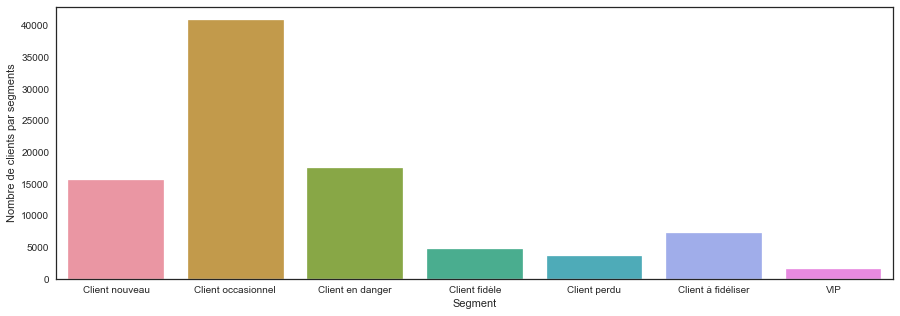

In [219]:
plt.figure(figsize=(15,5))
sns.countplot('description',data=rfm)
plt.xlabel('Segment')
plt.ylabel('Nombre de clients par segments')

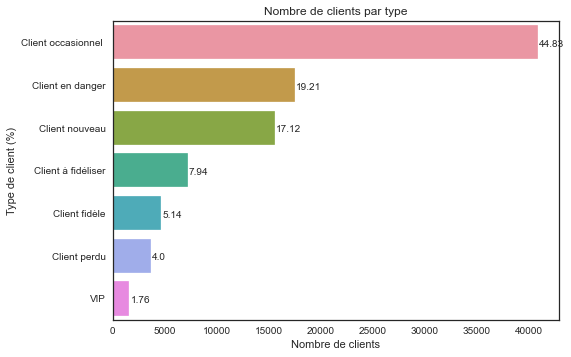

In [220]:
ax1 = plt.gca()
nb_client = rfm['description'].shape[0]
series_type_client = rfm['description'].value_counts()
df_type_client = pd.DataFrame(
    {'Type_client': series_type_client.index,
     'Nb_clients': series_type_client.values})
df_type_client['%'] = round((df_type_client['Nb_clients'])*100/nb_client, 2)

# Barplot de la distribution
sns.set_style('white')
sns.barplot(y='Type_client', x='Nb_clients',data=df_type_client, ax=ax1)
ax1.set_ylabel('Type de client (%)')
ax1.set_xlabel('Nombre de clients')
ax1.set_title('Nombre de clients par type')
for i, p in enumerate(ax1.patches):
    ax1.text(
        p.get_width() +
        p.get_x() + 100,
        p.get_height() +
        p.get_y() - 0.3,
        df_type_client['%'][i],
        fontsize=10)
plt.show()